In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import dask.dataframe as dd 
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import re
import random
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import utils
from sklearn import metrics, svm
from math import sqrt
from sklearn.metrics import r2_score
%matplotlib inline
import xgboost as xgb

In [3]:
train = pd.read_csv('c:/Users/joe/desktop/train_2016_v2.csv',parse_dates=['transactiondate'])

# load the properties data
prp = pd.read_csv('c:/Users/joe/desktop/properties_2016.csv')

merged = pd.merge(train,prp,on='parcelid',how='left')

# Linear Variable Combinations
merged['property_age'] = 2018 - merged['yearbuilt']
merged['total_rooms'] = merged['calculatedbathnbr'] + merged['bedroomcnt']
merged['garage_yn'] = np.where((merged['garagecarcnt'] > 0) | (merged['garagetotalsqft'] > 0),1,0)
merged['prop_to_land'] = merged['structuretaxvaluedollarcnt']/merged['landtaxvaluedollarcnt']
merged['length_tax_delinq'] = 2018 - merged['taxdelinquencyyear']
merged['coords'] = merged['latitude']/(10^6) + merged['longitude']/(10^6)
zip_count = merged['regionidzip'].value_counts().to_dict()
merged['zip_counts'] = merged['regionidzip'].map(zip_count)
city_count = merged['regionidcity'].value_counts().to_dict()
merged['city_counts'] = merged['regionidcity'].map(city_count)
county_count = merged['regionidcounty'].value_counts().to_dict()
merged['county_counts'] = merged['regionidcounty'].map(county_count)
merged['ac_yn'] = (merged['airconditioningtypeid']!=5)*1
merged['heat_yn'] = (merged['heatingorsystemtypeid']!=13)*1
merged['property_type'] = merged.propertylandusetypeid.replace({31 : "Mixed", 46 : "Other", 47 : "Mixed",
      246 : "Mixed", 247 : "Mixed", 248 : "Mixed",
      260 : "Home", 261 : "Home", 262 : "Home",
      263 : "Home", 264 : "Home", 265 : "Home",
      266 : "Home", 267 : "Home", 268 : "Home",
      269 : "Not Built", 270 : "Home", 271 : "Home",
      273 : "Home", 274 : "Other", 275 : "Home",
      276 : "Home", 279 : "Home", 290 : "Not Built",
      291 : "Not Built" }) 
# structuretaxvaluedollarcnt by city
group = merged.groupby('regionidcity')['structuretaxvaluedollarcnt'].aggregate('mean').to_dict()
merged['stvdc_avg_bycity'] = merged['regionidcity'].map(group)
merged['stvdc_avg_dev'] = abs((merged['structuretaxvaluedollarcnt'] - merged['stvdc_avg_bycity']))/merged['stvdc_avg_bycity']


In [4]:
high = np.percentile(np.log(merged['taxvaluedollarcnt'].dropna()),99)
low = np.percentile(np.log(merged['taxvaluedollarcnt'].dropna()),1)
mor = merged[(np.log(merged['taxvaluedollarcnt']) > low) & (np.log(merged['taxvaluedollarcnt']) < high)]

In [5]:
#%%
# Random Forest Without Multicollinearity <200k
# Preprocessing
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = mor['taxvaluedollarcnt']
data = data[data['taxvaluedollarcnt']<200000]
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'],axis=1)
y = data['target']
xtrain_200,xtest_200,ytrain_200,ytest_200 = train_test_split(X,y,test_size=0.33,random_state=42)
# Fit Random Forest
parameters = {'n_estimators':[500], 'n_jobs':[-1], 'oob_score':[False], }
model = RandomForestRegressor()
grid_200 = GridSearchCV(model,param_grid=parameters,scoring='neg_mean_absolute_error',cv=3)
grid_200.fit(xtrain_200,ytrain_200)
print("Random Forest MAE:",np.mean(np.abs(grid_200.predict(xtest_200)-ytest_200)))

Random Forest MAE: 5788.59153143539


R2: 0.9295


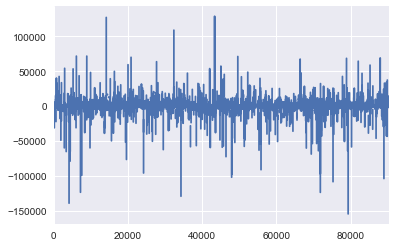

In [6]:
r2 = r2_score(ytest_200, grid_200.predict(xtest_200))
print("R2: %.4f" % r2)

data1 = data
data1['pred_diff'] = grid_200.predict(xtest_200)-ytest_200

data1['pred_diff'].plot()

In [7]:
# Random Forest Without Multicollinearity 200k > x > 350k
# Preprocessing
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = mor['taxvaluedollarcnt']
data = data[(data['taxvaluedollarcnt']>=200000) & (data['taxvaluedollarcnt']<350000)]
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'],axis=1)
y = data['target']
xtrain_350,xtest_350,ytrain_350,ytest_350 = train_test_split(X,y,test_size=0.33,random_state=42)
# Fit Random Forest
parameters = {'n_estimators':[500], 'n_jobs':[-1], 'oob_score':[False], }
model = RandomForestRegressor()
grid_350 = GridSearchCV(model,param_grid=parameters,scoring='neg_mean_absolute_error',cv=3)
grid_350.fit(xtrain_350,ytrain_350)
print("Random Forest MAE:",np.mean(np.abs(grid_350.predict(xtest_350)-ytest_350)))

Random Forest MAE: 14035.678437950883


R2: 0.7729


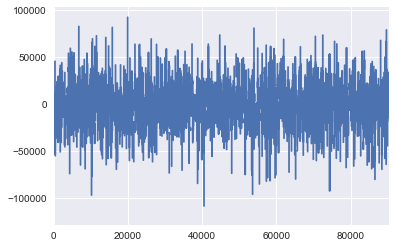

In [8]:
r2 = r2_score(ytest_350, grid_350.predict(xtest_350))
print("R2: %.4f" % r2)

data1 = data
data1['pred_diff'] = grid_350.predict(xtest_350)-ytest_350

data1['pred_diff'].plot()

In [10]:
# Random Forest Without Multicollinearity 350k > x > 500k
# Preprocessing
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = mor['taxvaluedollarcnt']
data = data[(data['taxvaluedollarcnt']>=350000) & (data['taxvaluedollarcnt']<500000)]
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'],axis=1)
y = data['target']
xtrain_500,xtest_500,ytrain_500,ytest_500 = train_test_split(X,y,test_size=0.33,random_state=42)
# Fit Random Forest
parameters = {'n_estimators':[1000], 'n_jobs':[-1], 'oob_score':[False], }
model = RandomForestRegressor()
grid_500 = GridSearchCV(model,param_grid=parameters,scoring='neg_mean_absolute_error',cv=3)
grid_500.fit(xtrain_500,ytrain_500)
print("Random Forest MAE:",np.mean(np.abs(grid_500.predict(xtest_500)-ytest_500)))

Random Forest MAE: 19777.8269848611


R2: 0.6266


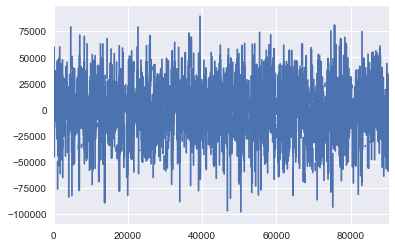

In [11]:
r2 = r2_score(ytest_500, grid_500.predict(xtest_500))
print("R2: %.4f" % r2)

data1 = data
data1['pred_diff'] = grid_500.predict(xtest_500)-ytest_500

data1['pred_diff'].plot()

In [12]:
# Random Forest Without Multicollinearity 500k > x > 1MM
# Preprocessing
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = mor['taxvaluedollarcnt']
data = data[(data['taxvaluedollarcnt']>=500000) & (data['taxvaluedollarcnt']<1000000)]
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'],axis=1)
y = data['target']
xtrain_1000,xtest_1000,ytrain_1000,ytest_1000 = train_test_split(X,y,test_size=0.33,random_state=42)
# Fit Random Forest
parameters = {'n_estimators':[5,10,15], 'n_jobs':[-1], 'oob_score':[False], }
model = RandomForestRegressor()
grid_1000 = GridSearchCV(model,param_grid=parameters,scoring='neg_mean_absolute_error',cv=3)
grid_1000.fit(xtrain_1000,ytrain_1000)
print("Random Forest MAE:",np.mean(np.abs(grid_1000.predict(xtest_1000)-ytest_1000)))

Random Forest MAE: 51938.030854250595


R2: 0.7048


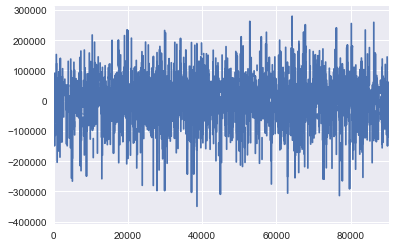

In [13]:
from sklearn.metrics import r2_score
r2 = r2_score(ytest_1000, grid_1000.predict(xtest_1000))
print("R2: %.4f" % r2)
data1 = data
data1['pred_diff'] = grid_1000.predict(xtest_1000)-ytest_1000

data1['pred_diff'].plot()

In [14]:
# Random Forest Without Multicollinearity 1MM > x > 10MM
# Preprocessing
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = mor['taxvaluedollarcnt']
data = data[(data['taxvaluedollarcnt']>=1000000) & (data['taxvaluedollarcnt']<10000000)]
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'],axis=1)
y = data['target']
xtrain_10000,xtest_10000,ytrain_10000,ytest_10000 = train_test_split(X,y,test_size=0.33,random_state=42)
# Fit Random Forest
parameters = {'n_estimators':[500], 'n_jobs':[-1], 'oob_score':[False], 'min_samples_leaf':[1],
               'max_features':['auto', 'sqrt']}
model = RandomForestRegressor()
grid_10000 = GridSearchCV(model,param_grid=parameters,scoring='neg_mean_absolute_error',cv=3)
grid_10000.fit(xtrain_10000,ytrain_10000)
print("Random Forest MAE:",np.mean(np.abs(grid_10000.predict(xtest_10000)-ytest_10000)))

Random Forest MAE: 120426.23945230099


R2: 0.7589


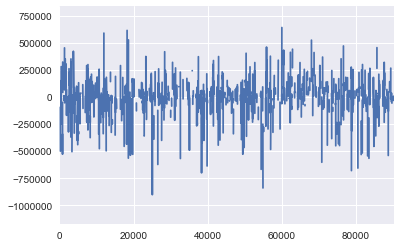

In [15]:
r2 = r2_score(ytest_10000, grid_10000.predict(xtest_10000))
print("R2: %.4f" % r2)
data1 = data
data1['pred_diff'] = grid_10000.predict(xtest_10000)-ytest_10000

data1['pred_diff'].plot()

In [18]:
#%%
#New Data Load With more transformations
train = pd.read_csv('c:/Users/joe/desktop/train_2016_v2.csv',parse_dates=['transactiondate'])

# load the properties data
prp = pd.read_csv('c:/Users/joe/desktop/properties_2016.csv')

merged = pd.merge(train,prp,on='parcelid',how='left')
#%%
# Linear Variable Combinations
merged['property_age'] = 2018 - merged['yearbuilt']
merged['total_rooms'] = merged['calculatedbathnbr'] + merged['bedroomcnt']
merged['garage_yn'] = np.where((merged['garagecarcnt'] > 0) | (merged['garagetotalsqft'] > 0),1,0)
#merged['prop_to_land'] = merged['structuretaxvaluedollarcnt']/merged['landtaxvaluedollarcnt']
merged['length_tax_delinq'] = 2018 - merged['taxdelinquencyyear']
merged['coords'] = merged['latitude']/(10^6) + merged['longitude']/(10^6)
zip_count = merged['regionidzip'].value_counts().to_dict()
merged['zip_counts'] = merged['regionidzip'].map(zip_count)
city_count = merged['regionidcity'].value_counts().to_dict()
merged['city_counts'] = merged['regionidcity'].map(city_count)
county_count = merged['regionidcounty'].value_counts().to_dict()
merged['county_counts'] = merged['regionidcounty'].map(county_count)
merged['ac_yn'] = (merged['airconditioningtypeid']!=5)*1
merged['heat_yn'] = (merged['heatingorsystemtypeid']!=13)*1
merged['property_type'] = merged.propertylandusetypeid.replace({31 : "Mixed", 46 : "Other", 47 : "Mixed",
      246 : "Mixed", 247 : "Mixed", 248 : "Mixed",
      260 : "Home", 261 : "Home", 262 : "Home",
      263 : "Home", 264 : "Home", 265 : "Home",
      266 : "Home", 267 : "Home", 268 : "Home",
      269 : "Not Built", 270 : "Home", 271 : "Home",
      273 : "Home", 274 : "Other", 275 : "Home",
      276 : "Home", 279 : "Home", 290 : "Not Built",
      291 : "Not Built" }) 
# structuretaxvaluedollarcnt by city
group = merged.groupby('regionidcity')['structuretaxvaluedollarcnt'].aggregate('mean').to_dict()
merged['stvdc_avg_bycity'] = merged['regionidcity'].map(group)
#merged['stvdc_avg_dev'] = abs((merged['structuretaxvaluedollarcnt'] - merged['stvdc_avg_bycity']))/merged['stvdc_avg_bycity']
#%%
high = np.percentile(merged['taxvaluedollarcnt'].dropna(),99)
low = np.percentile(merged['taxvaluedollarcnt'].dropna(),1)
mor = merged[((merged['taxvaluedollarcnt']) > low) & ((merged['taxvaluedollarcnt']) < high)]
#%%
#New Variable Buckets
mor['LandValueBuckets'] = pd.cut(mor.landtaxvaluedollarcnt,[0,100000,200000,300000,500000,3000000], include_lowest=True)
mor['YearBuiltBuckets'] = pd.cut(mor.yearbuilt, [0,1950,1970,1980,1990,2000,2020], include_lowest=True)
#ybbuckets = pd.get_dummies(mor['YearBuiltBuckets'])
#mor = mor.drop('YearBuiltBuckets',axis = 1)
#mor = mor.join(ybbuckets)

In [19]:
# Preprocessing
high = np.percentile(merged['taxvaluedollarcnt'].dropna(),99)
low = np.percentile(merged['taxvaluedollarcnt'].dropna(),1)
mor = merged[(merged['taxvaluedollarcnt'] > low) & (merged['taxvaluedollarcnt'] < high)]

In [23]:
from xgboost import XGBRegressor
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = mor['taxvaluedollarcnt']
#data = data[(data['taxvaluedollarcnt']>=0) & (data['taxvaluedollarcnt']<500000)]
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate','taxamount','structuretaxvaluedollarcnt','coords'],axis=1)
y = data['target']
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.33,random_state=42)
model = XGBRegressor(n_estimators = 1000,
                     learning_rate = 0.05,
                    max_depth = 10,
                    min_child_weight = 5)
model.fit(xtrain, ytrain)
print("XGBoost MAE:",np.mean(np.abs(model.predict(xtest)-ytest)))

XGBoost MAE: 35159.04545332302


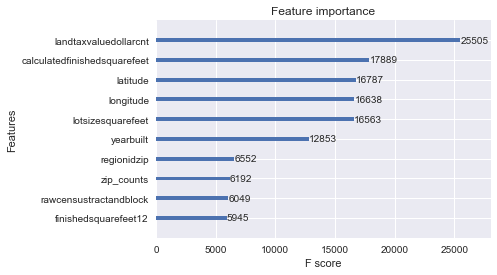

In [24]:
# Feature Importance Plot
from xgboost import plot_importance
plot_importance(model, max_num_features=10)
plt.show()

In [26]:
from sklearn.ensemble import GradientBoostingRegressor 
gbrmodel = GradientBoostingRegressor(n_estimators = 100,
                                    learning_rate = 0.05)
gbrmodel.fit(xtrain, ytrain)
print("Gradient Boosting Regression MAE:",np.mean(np.abs(model.predict(xtest)-ytest)))

Gradient Boosting Regression MAE: 35159.04545332302


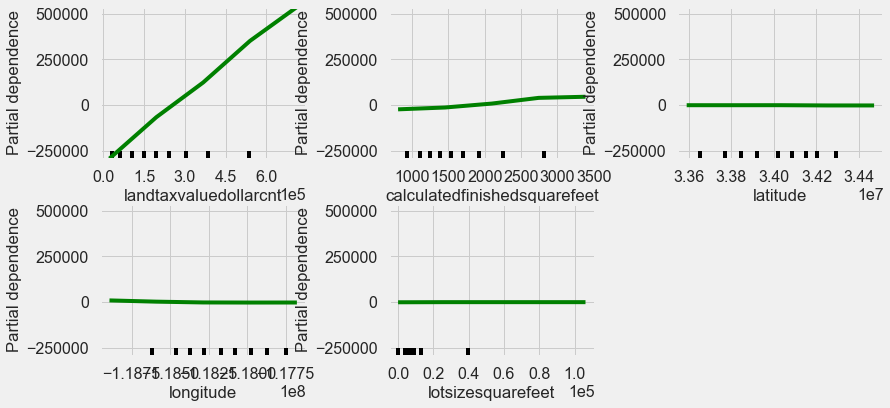

In [50]:
# Partial Dependence Plots For the top 5 features
sns.set_context('poster')
import matplotlib.style as style
style.use('fivethirtyeight')
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
pdplots = plot_partial_dependence(gbrmodel,       
                                   features=[46,10,22,23,24], # column numbers of plots we want to show
                                   X=xtrain,            # raw predictors data.
                                   feature_names=xtrain.columns, # labels on graphs
                                   grid_resolution=5) # number of values to plot on x axis
